In [78]:
import ray 

In [79]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-01-30 18:37:01,035	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.11
Ray version:,2.9.1


In [80]:
ray.cluster_resources()

{'node:__internal_head__': 1.0,
 'GPU': 1.0,
 'accelerator_type:G': 1.0,
 'memory': 2050321614.0,
 'CPU': 8.0,
 'object_store_memory': 1025160806.0,
 'node:192.168.1.9': 1.0}

In [4]:
num_workers = 6  # prefer to do a few less than total available CPU (1 for head node + 1 for background tasks)
resources_per_worker={"CPU": 1, "GPU": 0}

In [81]:
import pandas as pd 

In [82]:
DATASET_LOC='/home/suyash/mlops/Made-With-ML/datasets/dataset.csv'
df=pd.read_csv('/home/suyash/mlops/Made-With-ML/datasets/dataset.csv')
df.head()


,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [83]:
from sklearn.model_selection import train_test_split

In [84]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [85]:
test_size=0.2 
train_df,val_df=train_test_split(df,stratify=df.tag,test_size=test_size,random_state=1234)

In [86]:
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [87]:
from collections import Counter 
import matplotlib.pyplot as plt 
import seaborn as sns ; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS 


In [88]:
all_tags=Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

Text(0, 0.5, '# of projects')

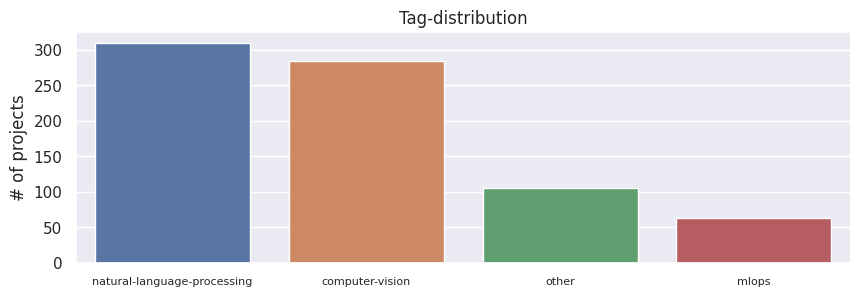

In [89]:
tags,tag_counts=zip(*all_tags.most_common())
plt.figure(figsize=(10,3)
)
ax=sns.barplot(x=list(tags),y=list(tag_counts))
ax.set_xticklabels(tags,rotation=0,fontsize=8)
plt.title("Tag-distribution")
plt.ylabel("# of projects")

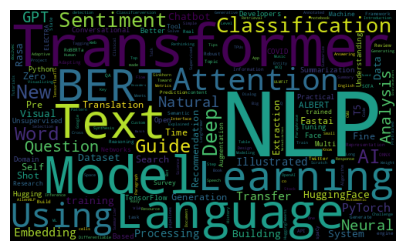

In [90]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

In [91]:
import json 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re 


In [92]:
df["text"]=df.title+" "+df.description

In [93]:
df.head()

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,Awesome Monte Carlo Tree Search A curated list...
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other,"AttentionWalk A PyTorch Implementation of ""Wat..."


In [94]:
nltk.download("stopwords")
STOPWORDS=stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/suyash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [96]:
original_df=df.copy()
df.text=df.text.apply(clean_text)

In [97]:
idf=df.drop(columns=["id","created_on","title"])
df=df.dropna(subset=["tag"])
df=df[["text","tag"]]
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [98]:
#label to index encoding 
tags=train_df.tag.unique().tolist()
num_classes=len(tags)
class_to_index={tags:i for i,tags in enumerate(tags)}
class_to_index 

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [99]:
df["tag"]=df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [100]:
def decode(indices,index_to_class):
    return [index_to_class[index] for index in indices ]

In [101]:
index_to_class={v:k for k,v in class_to_index.items()}

In [102]:
#Tokenization 
import numpy as np 
from transformers import BertTokenizer 


In [103]:
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)


In [104]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs=tokenizer(batch["text"].tolist(),return_tensors="np",padding="longest")

    return dict(ids=encoded_inputs["input_ids"],mask=encoded_inputs["attention_mask"],targets=np.array(batch["tag"]))

In [105]:
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

In [106]:
def preprocess(df,class_to_index):
    df["text"] = df.title + " " + df.description
      # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)

    return outputs 




In [107]:
preprocess(df=train_df, class_to_index=class_to_index)


{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1,

In [108]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic


In [109]:
ds=ray.data.read_csv('/home/suyash/mlops/Made-With-ML/datasets/dataset.csv')
ds=ds.random_shuffle(seed=1234)
ds.take(1)


2024-01-30 18:38:42,142	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=16 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (8).
2024-01-30 18:38:42,150	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2024-01-30 18:38:42,151	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-01-30 18:38:42,152	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-30 18:38:42,153	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataCon

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 428,
  'created_on': datetime.datetime(2020, 4, 10, 4, 57, 53),
  'title': 'AiLight: Automatic  Highlighting Using BERT',
  'description': 'Automatically highlight pdfs using BERT embeddings and clustering.\nhttps://anishthite.github.io/ailight',
  'tag': 'natural-language-processing'}]

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [121]:
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}


NameError: name 'train_ds' is not defined

In [ ]:
sample_ds = train_ds.map_batches(
  preprocess,
  fn_kwargs={"class_to_index": class_to_index},
  batch_format="pandas")
sample_ds.show(1)


In [60]:
import os 
import random 
import torch 
from ray.data.preprocessor import Preprocessor


In [61]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [63]:
def load_data(num_samples=None):
    ds=ray.data.read_csv(DATASET_LOC)
    ds=ds.random_shuffle(seed=1234)
    ds=ray.data.from_items(ds.take(num_samples)) if num_samples else ds 
    return ds 

In [64]:
from ray.data import Dataset


class CustomPreprocessor(Preprocessor):
    """custom preprocessor class"""
    def _fit(self,ds):
        tags=ds.unique(columns="tags")
        self.class_to_index={tag:i for tag,i in enumerate(tags)}
        self.index_to_class={v:k for k,v in self.class_to_index}
    def _transform_pandas(self,batch):
        return preprocess(batch,class_to_index=self.class_to_index)

In [69]:
import torch.nn as nn 
from transformers import BertModel
import torch.nn.functional as F 

In [66]:
llm=BertModel.from_pretrained("allenai/scibert_scivocab_uncased",return_dict=False)
embedding_dim=llm.config.hidden_size

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
embedding_dim

768

In [68]:
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq),np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [70]:
class FinetunnedLLM(nn.Module):
    def __init__(self,llm,dropout_p,embedding_dim,num_classes):

        super(FinetunnedLLM,self).__init__()
        self.llm=llm 
        self.dropout=torch.nn.Dropout(dropout_p)
        self.fc1=torch.nn.Linear(embedding_dim,num_classes) 

    def forward(self,batch):
        ids,masks=batch["ids"],batch["masks"]
        seq,pool =self.llm(input_ids=ids,attention_mask=masks)
        z=self.dropout(pool)
        z=self.fc1(z)
        return z 

    @torch.inference_mode()
    def predict(self,batch):
        self.eval()
        z=self(batch)
        y_pred=torch.argmax(z,dim=1).cpu().numpy()
        return y_pred 

    @torch.inference_mode()
    def predict_proba(self,batch):
        self.eval()
        z=self(batch)
        y_probs=F.softmax(z).cpu().numpy()
        return y_probs 
        
    

In [71]:
model=FinetunnedLLM(llm=llm,dropout_p=0.5,embedding_dim=embedding_dim,num_classes=num_classes)
print(model.named_parameters)

<bound method Module.named_parameters of FinetunnedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [72]:
from ray.train.torch import get_device

In [73]:
def pad_array(arr,dtype=np.int32):
    max_len=max(len(row) for row in arr)
    padded_arr=np.zeros((arr.shape[0],max_len),dtype=dtype)
    for i ,row in enumerate(arr):
        padded_arr[i][:len(row)]=row
    return padded_arr

In [74]:
def collate_fn(batch):
    batch["ids"]=pad_array(batch["ids"])
    batch["masks"]=pad_array(batch["masks"])
    dtypes={"ids":torch.int32,"masks":torch.int32,"targets":torch.int64}
    tensor_batch={}
    for key,array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    
    return tensor_batch
